# Week 6 Exercise - Census Data

This exercise has you apply two things:

- Obtaining data from the census (see the [tutorial notebook](https://cs533.ekstrandom.net/f21/resources/tutorials/UsingTheCensus/)
- Plotting two related numeric variables

The guiding question for this notebook is “is a higher level of college education in the population correlated with income?”

Let's go!

## Setup

We first need to make sure we have the `census` and `US` packages:

In [1]:
%pip install census us

Note: you may need to restart the kernel to use updated packages.


And then we can import:

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from census import Census
from us import states

And set up a census object (replace API KEY with your API key):

In [3]:
c = Census('829119ee66068d44227c9769ac2cf4f03aed308e')

## Census Data

The census data comes in a variety of *files*. These files include:

- `sf1` — Summary File 1, containing complete count information on the *decennial* census.
- `acs1` — American Community Survey, a supplementary annual survey of a sample of the population carried out by the census bureau every year.

Both of these files are accessed in the same way, via the Census object, but they contain different variables.  Each contains thousands of variables.

This notebook focuses on the ACS.  The [variable list](https://api.census.gov/data/2014/acs/acs5/variables.html) describes these variables, and the ones of interest are all reported as **estimated population counts**.  That means variable `B06009_003E` is an estimate, based on the sample, of the number of people in a geographic region whose highest educational attainment is a high school degree.

To fetch data, we need to know three things:

- The *geographic level* we want: county or state?
- *Which* geographic area(s)?
- The variables to retrieve.
- The year. We're going to use 2014.

Variables in turn are nested. Many variables are estimated population counts; for these, one variable is the total population, and others are counts within subgroups.  Look at the variable list to see how these are described:

- `B01001_001E` is the estimated total population
- `B01001_002E` is the estimated male population
- `B01001_026E` is the estimated female population

There are variables for a *lot* of different breakdowns.

The API returns a list of dictionaries containing the variables.  Let's get the gender population estimate for Idaho:

In [4]:
c.acs1.state(('NAME', 'B01001_001E', 'B01001_002E', 'B01001_026E'), states.ID.fips, year=2014)

[{'NAME': 'Idaho',
  'B01001_001E': 1634464.0,
  'B01001_002E': 817050.0,
  'B01001_026E': 817414.0,
  'state': '16'}]

Regions are identified by **FIPS codes**: numeric codes that identify states and counties.  Each state has a 2-digit FIPS code, and the `us.states` module lets us look up a state's FIPS code.  (We can also get a [table of them](https://www.census.gov/library/reference/code-lists/ansi/ansi-codes-for-states.html).)

Each county's code is a 5-digit number: its state code, followed by 3 digits to identify the county.

When calling `state`, we can provide `'*'` instead of a FIPS code to request all states, and use Pandas `from_records` to make a data frame:

In [5]:
gender_pop = pd.DataFrame.from_records(
    c.acs1.state(('NAME', 'B01001_001E', 'B01001_002E', 'B01001_026E'), '*', year=2014)
)
gender_pop.head()

,NAME,B01001_001E,B01001_002E,B01001_026E,state
0,Alabama,4849377.0,2347969.0,2501408.0,01
1,Alaska,736732.0,385582.0,351150.0,02
2,Arizona,6731484.0,3342946.0,3388538.0,04
3,Arkansas,2966369.0,1456778.0,1509591.0,05
4,California,38802500.0,19264457.0,19538043.0,06


In [6]:
gender_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   NAME         52 non-null     object 
 1   B01001_001E  52 non-null     float64
 2   B01001_002E  52 non-null     float64
 3   B01001_026E  52 non-null     float64
 4   state        52 non-null     object 
dtypes: float64(3), object(2)
memory usage: 2.2+ KB


Why is total a string?  Let's make it an int:

In [7]:
gender_pop['B01001_001E'] = gender_pop['B01001_001E'].astype('i4')
gender_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   NAME         52 non-null     object 
 1   B01001_001E  52 non-null     int32  
 2   B01001_002E  52 non-null     float64
 3   B01001_026E  52 non-null     float64
 4   state        52 non-null     object 
dtypes: float64(2), int32(1), object(2)
memory usage: 2.0+ KB


✅ **Todo:** do the following:

- Rename the columns to have meaningful names
- Compute the fraction of the population that is female in each state
- Plot the distribution of '% female'

In [8]:
gender_pop.rename(columns={'B01001_001E':'totalPop', 'B01001_002E':'malePop', 'B01001_026E':'femalePop'},inplace=True)
gender_pop.head()

,NAME,totalPop,malePop,femalePop,state
0,Alabama,4849377,2347969.0,2501408.0,01
1,Alaska,736732,385582.0,351150.0,02
2,Arizona,6731484,3342946.0,3388538.0,04
3,Arkansas,2966369,1456778.0,1509591.0,05
4,California,38802500,19264457.0,19538043.0,06


In [9]:
gender_pop['feFrac']=gender_pop['femalePop'].div(gender_pop['totalPop'])*100
gender_pop.head()

,NAME,totalPop,malePop,femalePop,state,feFrac
0,Alabama,4849377,2347969.0,2501408.0,01,51.582049
1,Alaska,736732,385582.0,351150.0,02,47.663194
2,Arizona,6731484,3342946.0,3388538.0,04,50.338647
3,Arkansas,2966369,1456778.0,1509591.0,05,50.890196
4,California,38802500,19264457.0,19538043.0,06,50.352537


## Educational Attainment and Income

The [06009](https://www.socialexplorer.com/data/ACS2014_5yr/metadata/?ds=ACS14_5yr&table=B06009) variables (`B06009_001E` and subcounts) report the number of people whose highest education is at at different levels. `B06009_002E` is people who have not completed high school, etc.  The [07011](https://www.socialexplorer.com/data/ACS2014_5yr/metadata/?ds=ACS14_5yr&table=B07011) variable reports the median income (`B07011_001E` is an estimate of median income - it is one of the variables that is *not* reported as a population count).

1. Fetch these variables for all states.
2. Compute the **fraction** of the population that has at least completed college.  Look at the variable list to see which variables you will need.
3. Show the distribution of this variable.

/home/chibuzoukegbu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='feFrac', ylabel='Density'>

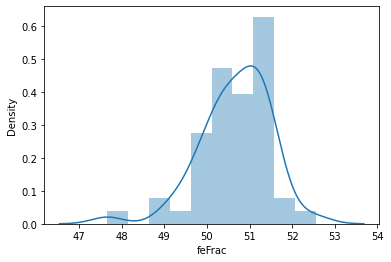

In [10]:
#plt.figure(figsize=(5,10))
sns.distplot(gender_pop['feFrac'],kde=True)

Not all variables are counts! `B07011_001E` is the **median income** for a region.

Fetch it too, and show *its* distribution!

In [11]:
c.acs1.state(('NAME', 'B06009_001E', 'B06009_002E', 'B07011_001E'), states.ID.fips, year=2014)

[{'NAME': 'Idaho',
  'B06009_001E': 1045193.0,
  'B06009_002E': 103178.0,
  'B07011_001E': 23448.0,
  'state': '16'}]


Now, look at the question: do states with a higher fraction of their education college-educated have higher median incomes?  Show with a scatterplot and compute a correlation coefficient (Pandas `.corr` method).

In [12]:
gender_pop1= pd.DataFrame.from_records(
    c.acs1.state(('NAME', 'B06009_001E', 'B06009_002E', 'B07011_001E'), '*', year=2014)
)
gender_pop1.head()

,NAME,B06009_001E,B06009_002E,B07011_001E,state
0,Alabama,3256766.0,497759.0,22327.0,01
1,Alaska,465149.0,33253.0,31557.0,02
2,Arizona,4436226.0,618786.0,26070.0,04
3,Arkansas,1968414.0,288737.0,22179.0,05
4,California,25654292.0,4593525.0,26997.0,06


In [14]:
gender_pop1=gender_pop1.rename(columns={'B06009_001E':'people_edu_level_count','B06009_002E':'people_without_high_school','B07011_001E':'est_median_income'})
gender_pop1.head()

,NAME,people_edu_level_count,people_without_high_school,est_median_income,state
0,Alabama,3256766.0,497759.0,22327.0,01
1,Alaska,465149.0,33253.0,31557.0,02
2,Arizona,4436226.0,618786.0,26070.0,04
3,Arkansas,1968414.0,288737.0,22179.0,05
4,California,25654292.0,4593525.0,26997.0,06


In [15]:
gender_pop1['atleast_college_edu']=gender_pop1['people_edu_level_count']-gender_pop1['people_without_high_school']

In [16]:
gender_pop1['atleast_college_edu_frac']= gender_pop1['atleast_college_edu']/gender_pop1['people_edu_level_count']
gender_pop1.head()

,NAME,people_edu_level_count,people_without_high_school,est_median_income,state,atleast_college_edu,atleast_college_edu_frac
0,Alabama,3256766.0,497759.0,22327.0,01,2759007.0,0.847162
1,Alaska,465149.0,33253.0,31557.0,02,431896.0,0.928511
2,Arizona,4436226.0,618786.0,26070.0,04,3817440.0,0.860515
3,Arkansas,1968414.0,288737.0,22179.0,05,1679677.0,0.853315
4,California,25654292.0,4593525.0,26997.0,06,21060767.0,0.820945


## County Level

(if you have time)

The `c.acs1.state_county` method fetches county-level data.  For example, to fetch data from counties in Idaho:

A lot of counties are missing, because there is not enough sample data from them.

You can provide `'*'` for both state and county, to get all counties in the US (for which data is available).

Look at education and income at the county level!

<AxesSubplot:>

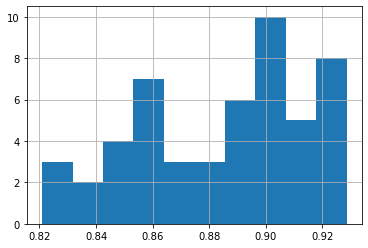

In [17]:
gender_pop1['atleast_college_edu_frac'].hist(bins=10)

<AxesSubplot:>

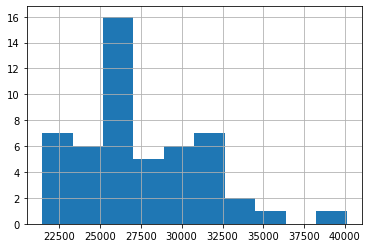

In [18]:
gender_pop1['est_median_income'].hist(bins=10)

/home/chibuzoukegbu/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='atleast_college_edu_frac', ylabel='est_median_income'>

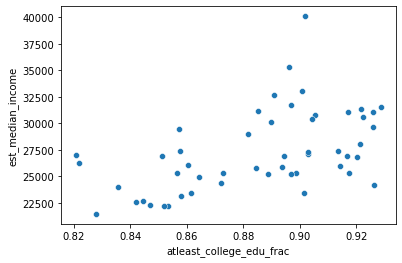

In [19]:
sns.scatterplot('atleast_college_edu_frac','est_median_income',data=gender_pop1)

In [20]:
gender_pop1.corr()['est_median_income']['atleast_college_edu_frac']

0.5055876111044691

In [21]:
gender_pop1_county=pd.DataFrame.from_records(
    c.acs1.state_county(('NAME', 'B06009_001E', 'B06009_002E', 'B07011_001E'), '*', '*', year=2014)
)
gender_pop1_county

,NAME,B06009_001E,B06009_002E,B07011_001E,state,county
0,"Santa Cruz County, California",175924.0,23708.0,27000.0,06,087
1,"Shasta County, California",125999.0,11325.0,22980.0,06,089
2,"Solano County, California",289822.0,37577.0,30657.0,06,095
3,"Sonoma County, California",352785.0,43768.0,30722.0,06,097
4,"Stanislaus County, California",332346.0,71835.0,23227.0,06,099
...,...,...,...,...,...,...
823,"Ponce Municipio, Puerto Rico",NaN,NaN,NaN,72,113
824,"Toa Alta Municipio, Puerto Rico",NaN,NaN,NaN,72,135
825,"Carolina Municipio, Puerto Rico",NaN,NaN,NaN,72,031
826,"Guaynabo Municipio, Puerto Rico",NaN,NaN,NaN,72,061


In [22]:
gender_pop1_county=gender_pop1_county.rename(columns={
    'B06009_001E':'people_edu_level_count','B06009_002E':'people_without_high_school','B07011_001E':'est_median_income'
})
gender_pop1_county

,NAME,people_edu_level_count,people_without_high_school,est_median_income,state,county
0,"Santa Cruz County, California",175924.0,23708.0,27000.0,06,087
1,"Shasta County, California",125999.0,11325.0,22980.0,06,089
2,"Solano County, California",289822.0,37577.0,30657.0,06,095
3,"Sonoma County, California",352785.0,43768.0,30722.0,06,097
4,"Stanislaus County, California",332346.0,71835.0,23227.0,06,099
...,...,...,...,...,...,...
823,"Ponce Municipio, Puerto Rico",NaN,NaN,NaN,72,113
824,"Toa Alta Municipio, Puerto Rico",NaN,NaN,NaN,72,135
825,"Carolina Municipio, Puerto Rico",NaN,NaN,NaN,72,031
826,"Guaynabo Municipio, Puerto Rico",NaN,NaN,NaN,72,061
